# Create climate dataset for capitals in Europe

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# to resolve xarray FutureWarning
xr.set_options(use_new_combine_kwarg_defaults=True)

In [2]:
# mapping between variable names in ISIMIP data and ERA5 dataset

mappings = {
    'tas': 't2m',
    'pr': 'tp',
    'prsn': 'sf',
    'sfcwind': 'si10',
    'tasmax': 'max_t2m',
    'tasmin': 'min_t2m',
}

In [3]:
# Check all available datasets first
eu_capitals = pd.read_csv("datasets/eu_capitals.csv")
print(eu_capitals.shape)
eu_capitals.head()

(58, 3)


,name,latitude,longitude
0,Mariehamn,60.00,20.00
1,Tirana,41.25,19.75
2,Andorra la Vella,42.50,1.50
3,Yerevan,40.25,44.50
4,Vienna,48.25,16.25


In [4]:
bern = eu_capitals[eu_capitals['name'] == 'Bern']
display(bern)

,name,latitude,longitude
53,Bern,47.0,7.5


In [5]:
periods = ['2011_2014', '2021_2030', '2031_2040', '2041_2050']
features = ['pr', 'prsn', 'sfcwind', 'tas', 'tasmax', 'tasmin']
datasets = {}

for feature in features:
    for period in periods:
        if period == '2011_2014':
            file_path = f"isimip3b_IPSL_CM6A_LR/historical/{feature}/ipsl-cm6a-lr_r1i1p1f1_w5e5_historical_{feature}_global_daily_{period}.nc"
        else:
            file_path = f"isimip3b_IPSL_CM6A_LR/ssp585/{feature}/ipsl-cm6a-lr_r1i1p1f1_w5e5_ssp585_{feature}_global_daily_{period}.nc"
        ds = xr.open_dataset(file_path)
        datasets[f"{feature}_{period}"] = ds

datasets.keys()

dict_keys(['pr_2011_2014', 'pr_2021_2030', 'pr_2031_2040', 'pr_2041_2050', 'prsn_2011_2014', 'prsn_2021_2030', 'prsn_2031_2040', 'prsn_2041_2050', 'sfcwind_2011_2014', 'sfcwind_2021_2030', 'sfcwind_2031_2040', 'sfcwind_2041_2050', 'tas_2011_2014', 'tas_2021_2030', 'tas_2031_2040', 'tas_2041_2050', 'tasmax_2011_2014', 'tasmax_2021_2030', 'tasmax_2031_2040', 'tasmax_2041_2050', 'tasmin_2011_2014', 'tasmin_2021_2030', 'tasmin_2031_2040', 'tasmin_2041_2050'])

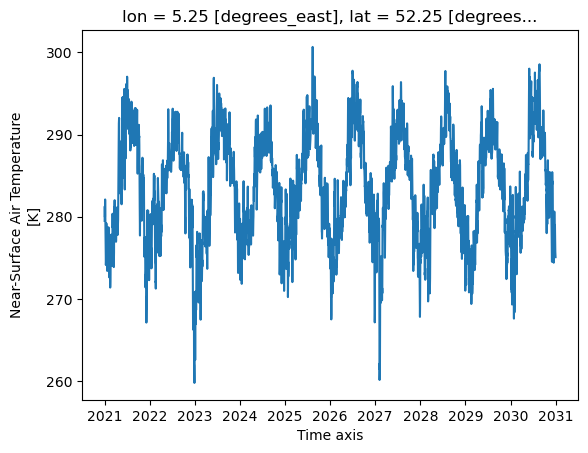

In [8]:
datasets['tas_2021_2030'].sel(lat=52, lon=5, method='nearest')['tas'].plot()

In [9]:
print("Nb of latitudes:", datasets['tas_2021_2030']['lat'].size)
print("Nb of longitudes:", datasets['tas_2021_2030']['lon'].size)
print("Time period:", str(datasets['tas_2021_2030']['time'].values[0])[:10], "to", str(datasets['tas_2021_2030']['time'].values[-1])[:10])

Nb of latitudes: 360
Nb of longitudes: 720
Time period: 2021-01-01 to 2030-12-31


## Keep only data in an area around Europe (lat: 35 to 72, lon: -25 to 45)

In [10]:
def keep_area_europe(dataset):
    """Keep only data in an area around Europe (lat: 35 to 72, lon: -25 to 45)"""
    europe_data = dataset.sel(lat=slice(72, 35), lon=slice(-25, 45))
    return europe_data

In [11]:
ds_europe = {}

for feature in features:
    for period in periods:
        ds_europe[f"{feature}_{period}"] = keep_area_europe(datasets[f"{feature}_{period}"])

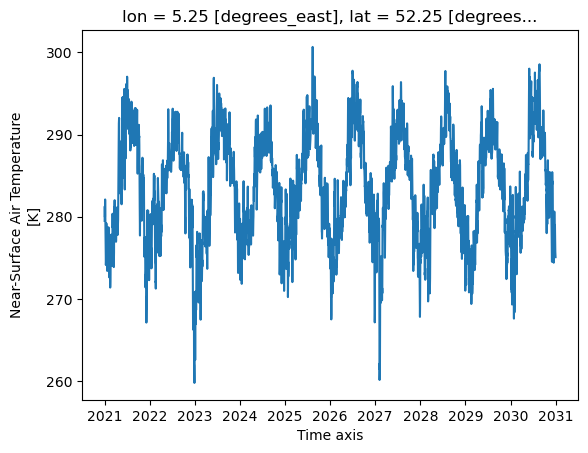

In [12]:
ds_europe['tas_2021_2030'].sel(lat=52, lon=5, method='nearest')['tas'].plot()

In [13]:
ds_europe['tas_2021_2030']

<xarray.Dataset> Size: 151MB
Dimensions:  (time: 3652, lat: 74, lon: 140)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2021-01-01T12:00:00 ... 2030-12-31T12...
  * lat      (lat) float64 592B 71.75 71.25 70.75 70.25 ... 36.25 35.75 35.25
  * lon      (lon) float64 1kB -24.75 -24.25 -23.75 -23.25 ... 43.75 44.25 44.75
Data variables:
    tas      (time, lat, lon) float32 151MB ...
Attributes:
    title:        ISIMIP3b bias-adjusted climate input data
    institution:  Potsdam Institute for Climate Impact Research (PIK)
    project:      Inter-Sectoral Impact Model Intercomparison Project phase 3...
    contact:      ISIMIP cross-sectoral science team <info@isimip.org> <https...
    summary:      CMIP6 daily output data bias-adjusted and statistically dow...
    references:   Lange (2019) <https://doi.org/10.5194/gmd-12-3055-2019> and...

## Convert units to match ERA5 dataset (precipitation and snowfall from kg m-2 s-1 to m)

#### Units comparison between ERA5 and ISIMIP3b:

| Feature             | ERA5 Unit  | ISIMIP3b Unit |
| ------------------- | ---------- | ------------- |
| 2m Temperature      | Kelvin (K) | K             |
| wind speed          | m s^-1    | m s^-1        |
| total precipitation | m          | kg m^-2 s^-1  |
| snowfall            | m          | kg m^-2 s^-1  |

- 1 kg m⁻² = 1 mm water
- precipitation rate is for one day -> multiply by 86400 (seconds in a day) and convert mm to m (divide by 1000)

In [14]:
def convert_precipitation_units(dataset):
    """Convert precipitation and snowfall from kg m-2 s-1 to m"""
    return dataset / 1000 * 86400  # Convert from kg m-2 s-1 to m

In [15]:
features_to_convert = ['pr', 'prsn']

for feature in features_to_convert:
    for period in periods:
        print(f"Converting units for {feature} in period {period}")
        ds_europe[f"{feature}_{period}"] = convert_precipitation_units(ds_europe[f"{feature}_{period}"])

Converting units for pr in period 2011_2014
Converting units for pr in period 2021_2030
Converting units for pr in period 2031_2040
Converting units for pr in period 2041_2050
Converting units for prsn in period 2011_2014
Converting units for prsn in period 2021_2030
Converting units for prsn in period 2031_2040
Converting units for prsn in period 2041_2050


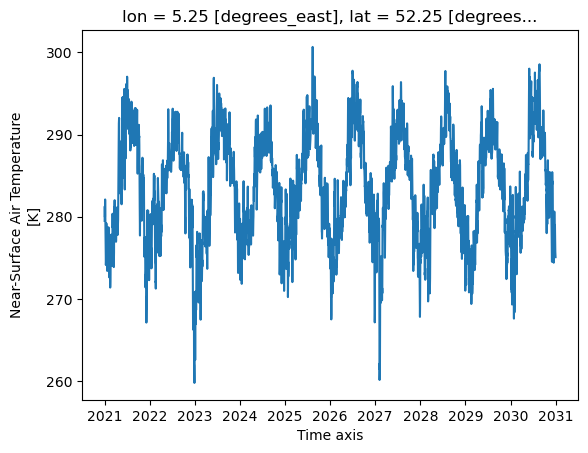

In [17]:
ds_europe['tas_2021_2030'].sel(lat=52, lon=5, method='nearest')['tas'].plot()

## Keep data within a radius of 50km (0.45 degrees) around each capital

In [18]:
def reduce_dataset_to_cities(dataset, cities_df, radius_deg=0.45) -> xr.Dataset:
    """Fully vectorized version using broadcasting."""
    
    # Extraire les coordonnées
    lats_cities = cities_df['latitude'].values
    lons_cities = cities_df['longitude'].values
    names = cities_df['name'].values
    
    lat_grid = dataset['lat'].values
    lon_grid = dataset['lon'].values
    
    # Charger les données en mémoire (si possible)
    data_vars = list(dataset.data_vars)
    
    # Préparer les listes pour stocker les villes valides
    n_time = dataset.sizes['time']
    valid_indices = []
    valid_names = []
    valid_lats = []
    valid_lons = []
    results_dict = {var: [] for var in data_vars}
    
    # Treat each city in one loop
    for i, (lat_city, lon_city, name) in enumerate(zip(lats_cities, lons_cities, names)):
        # booleans masks for lat/lon within radius
        lat_mask = (lat_grid >= lat_city - radius_deg) & (lat_grid <= lat_city + radius_deg)
        lon_mask = (lon_grid >= lon_city - radius_deg) & (lon_grid <= lon_city + radius_deg)
        
        n_points = np.sum(lat_mask) * np.sum(lon_mask)

        if n_points == 0:
            print(f"Warning: No grid points found within radius {radius_deg} degrees for city {name}. Skipping.")
            continue
        
        # Ville valide - ajouter aux listes
        valid_indices.append(i)
        valid_names.append(name)
        valid_lats.append(lat_city)
        valid_lons.append(lon_city)
        
        # Extraire et moyenner pour chaque variable
        for var in data_vars:
            data_subset = dataset[var].values[:, lat_mask][:, :, lon_mask]
            averaged_data = np.nanmean(data_subset, axis=(1, 2))
            results_dict[var].append(averaged_data)
    
    # Convertir les listes en arrays numpy
    valid_names = np.array(valid_names)
    valid_lats = np.array(valid_lats)
    valid_lons = np.array(valid_lons)
    
    for var in data_vars:
        results_dict[var] = np.column_stack(results_dict[var])  # (n_time, n_valid_cities)
    
    # Créer le dataset de sortie avec time et city comme dimensions principales
    data_arrays = {}
    for var in data_vars:
        data_arrays[var] = xr.DataArray(
            results_dict[var],
            dims=('time', 'city'),
            coords={
                'time': dataset['time'],
                'city': valid_names
            }
        )
    
    result_ds = xr.Dataset(data_arrays)
    
    # Ajouter latitude et longitude comme coordonnées indexées sur la dimension 'city'
    result_ds = result_ds.assign_coords({
        'latitude': ('city', valid_lats),
        'longitude': ('city', valid_lons)
    })
    
    print(f"Processed {len(valid_names)} cities out of {len(names)} total.")
    
    return result_ds

In [19]:
# Faire en sorte de passer une seule fois par époque donc toutes les variables d'un coup

ds_reduced = {}

for feature in features:
    for period in periods:
        print(f"Processing {feature} for period {period}...")
        ds_reduced[f"{feature}_{period}"] = reduce_dataset_to_cities(
            ds_europe[f"{feature}_{period}"],
            eu_capitals,
            radius_deg=0.45
        )

Processing pr for period 2011_2014...
Processed 56 cities out of 58 total.
Processing pr for period 2021_2030...
Processed 56 cities out of 58 total.
Processing pr for period 2031_2040...
Processed 56 cities out of 58 total.
Processing pr for period 2041_2050...
Processed 56 cities out of 58 total.
Processing prsn for period 2011_2014...
Processed 56 cities out of 58 total.
Processing prsn for period 2021_2030...
Processed 56 cities out of 58 total.
Processing prsn for period 2031_2040...
Processed 56 cities out of 58 total.
Processing prsn for period 2041_2050...
Processed 56 cities out of 58 total.
Processing sfcwind for period 2011_2014...
Processed 56 cities out of 58 total.
Processing sfcwind for period 2021_2030...
Processed 56 cities out of 58 total.
Processing sfcwind for period 2031_2040...
Processed 56 cities out of 58 total.
Processing sfcwind for period 2041_2050...
Processed 56 cities out of 58 total.
Processing tas for period 2011_2014...
Processed 56 cities out of 58 tot

In [20]:
ds_reduced['tas_2021_2030']

<xarray.Dataset> Size: 852kB
Dimensions:    (time: 3652, city: 56)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2021-01-01T12:00:00 ... 2030-12-31T...
  * city       (city) <U16 4kB 'Mariehamn' 'Tirana' ... 'London' 'North Nicosia'
    latitude   (city) float64 448B 60.0 41.25 42.5 40.25 ... 50.5 51.5 35.25
    longitude  (city) float64 448B 20.0 19.75 1.5 44.5 ... 32.75 30.5 -0.0 33.25
Data variables:
    tas        (time, city) float32 818kB 273.4 281.8 275.0 ... 273.1 286.3

In [21]:
# Verify dimension
print("Dataset dimensions before reduction:", datasets['tas_2021_2030'].dims)
print("Dataset dimensions after reduction:", ds_reduced['tas_2021_2030'].dims)

Dataset dimensions before reduction: FrozenMappingWarningOnValuesAccess({'time': 3652, 'lat': 360, 'lon': 720})
Dataset dimensions after reduction: FrozenMappingWarningOnValuesAccess({'time': 3652, 'city': 56})


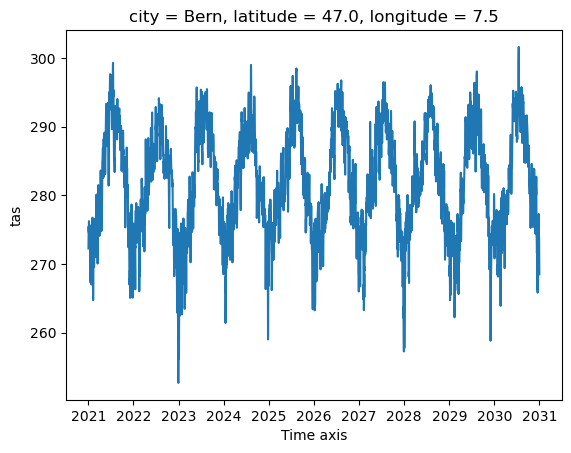

In [24]:
ds_reduced['tas_2021_2030'].sel(city='Bern')['tas'].plot()

## Aggregate daily data to seasonal data

In [25]:
def aggregate_monthly(dataset):
    """Aggregate daily data to monthly data by taking the mean over each month."""
    monthly_data = dataset.resample(time='ME').mean()
    return monthly_data

def aggregate_per_season(dataset):
    """Aggregate daily data to seasonal data by taking the mean over each season."""
    seasonal_data = dataset.resample(time='QS-DEC').mean()
    return seasonal_data

In [26]:
ds_seasonal = {}

for feature in features:
    for period in periods:
        ds_seasonal[f"{feature}_{period}"] = aggregate_per_season(ds_reduced[f"{feature}_{period}"])

In [27]:
ds_seasonal['tas_2021_2030']

<xarray.Dataset> Size: 14kB
Dimensions:    (time: 41, city: 56)
Coordinates:
  * time       (time) datetime64[ns] 328B 2020-12-01 2021-03-01 ... 2030-12-01
  * city       (city) <U16 4kB 'Mariehamn' 'Tirana' ... 'London' 'North Nicosia'
    latitude   (city) float64 448B 60.0 41.25 42.5 40.25 ... 50.5 51.5 35.25
    longitude  (city) float64 448B 20.0 19.75 1.5 44.5 ... 32.75 30.5 -0.0 33.25
Data variables:
    tas        (time, city) float32 9kB 274.9 279.8 273.3 ... 272.5 277.7 285.6

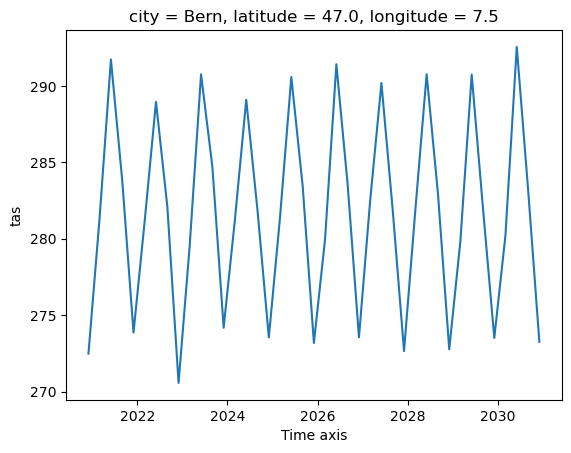

In [28]:
ds_seasonal['tas_2021_2030'].sel(city='Bern')['tas'].plot()

In [29]:
# Verification
print(f"Original dataset time points: {ds_reduced['tas_2021_2030'].sizes['time']}")
# print(f"Monthly aggregated dataset time points: {ds_monthly['tas_2021_2030'].sizes['time']}")
print(f"Seasonal aggregated dataset time points: {ds_seasonal['tas_2021_2030'].sizes['time']}")

Original dataset time points: 3652
Seasonal aggregated dataset time points: 41


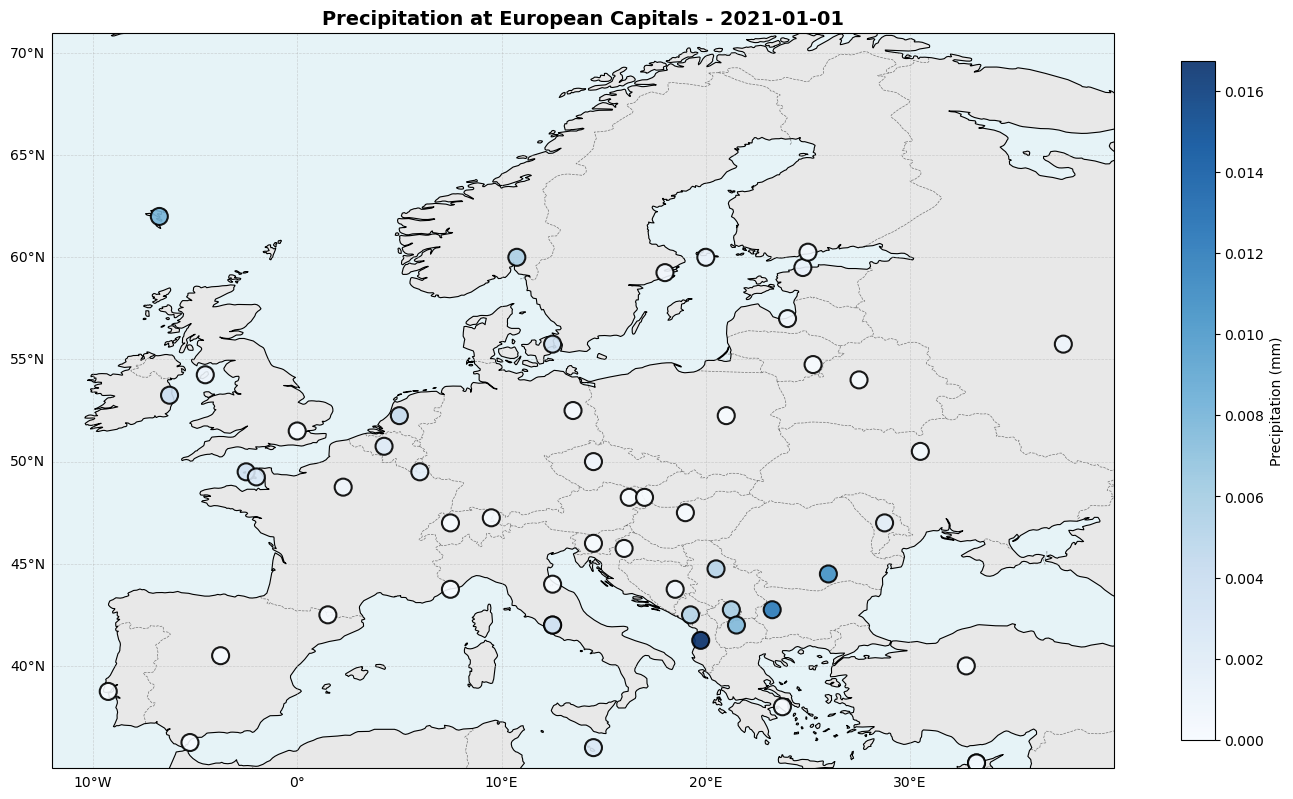

In [30]:
# Enhanced plot with Cartopy for better geographical representation

import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Extract precipitation values for the first time step
pr_values = ds_reduced['pr_2021_2030']['pr'][0].values  # Precipitation at first time step
lats = ds_reduced['pr_2021_2030'].latitude.values
lons = ds_reduced['pr_2021_2030'].longitude.values

# Plot scatter with correct transform
scatter = ax.scatter(lons, lats, c=pr_values, cmap='Blues', s=150, 
                     edgecolors='black', linewidths=1.5, 
                     transform=ccrs.PlateCarree(), zorder=5, alpha=0.9)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Precipitation (mm)', shrink=0.7, pad=0.05)

# Set extent to focus on Europe (West, East, South, North)
ax.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Format the time for the title
time_str = str(ds_reduced['pr_2021_2030'].time[0].values)[:10]
ax.set_title(f'Precipitation at European Capitals - {time_str}', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Average climate features for each decade

For each feature, for each capital (lat,lon), do the mean on 10 years for each month. For example, for the feature "2m temperature" (t2m), for the capital of France (48.8566, 2.3522), do the mean of all January data from 1970 to 1979, then do the mean of all February data from 1970 to 1979, and so on until December. Then repeat the same operation for the periods 1980-1989, 1990-1999, 2000-2009 and 2010-2020. In the end, we will have for each year, a dataset with 2 + 12 * 4 = 50 columns: latitude, longitude, and for each month (12) the 4 features (sf, tp, t2m, si10).

<img src="images/ds_columns_past_v2.png" style="width:1000px;"  />


In [50]:
def average_over_period(dataset, month) -> xr.Dataset:
    """Average the dataset over a specified time period."""
    period_data = dataset.sel(time=dataset['time.month'] == month)
    averaged_data = period_data.mean(dim='time')
    return averaged_data

In [53]:
ds_periods = {}
months = [12, 3, 6, 9]  # winter, spring, summer, autumn

for period in periods:
    for feature in features:
        ds_season = ds_seasonal[f"{feature}_{period}"]
        ds_result = xr.Dataset()
        for month in months:
            ds_month = average_over_period(
                ds_season,
                month
            )
            if ds_result.sizes:
                ds_result = xr.concat([ds_result, ds_month], dim='time')
            else:
                ds_result = ds_month
        ds_periods[f"{feature}_{period}"] = ds_result

In [54]:
ds_periods.keys()

dict_keys(['pr_2011_2014', 'prsn_2011_2014', 'sfcwind_2011_2014', 'tas_2011_2014', 'tasmax_2011_2014', 'tasmin_2011_2014', 'pr_2021_2030', 'prsn_2021_2030', 'sfcwind_2021_2030', 'tas_2021_2030', 'tasmax_2021_2030', 'tasmin_2021_2030', 'pr_2031_2040', 'prsn_2031_2040', 'sfcwind_2031_2040', 'tas_2031_2040', 'tasmax_2031_2040', 'tasmin_2031_2040', 'pr_2041_2050', 'prsn_2041_2050', 'sfcwind_2041_2050', 'tas_2041_2050', 'tasmax_2041_2050', 'tasmin_2041_2050'])

In [57]:
# print average seasonal tas for Bern in period 2021-2030

ds_periods['tas_2021_2030']['tas'].sel(city='Bern')

<xarray.DataArray 'tas' (time: 4)> Size: 16B
array([273.0465 , 280.87897, 290.68588, 282.92023], dtype=float32)
Coordinates:
    city       <U16 64B 'Bern'
    latitude   float64 8B 47.0
    longitude  float64 8B 7.5
Dimensions without coordinates: time

In [59]:
ds_periods.keys()

dict_keys(['pr_2011_2014', 'prsn_2011_2014', 'sfcwind_2011_2014', 'tas_2011_2014', 'tasmax_2011_2014', 'tasmin_2011_2014', 'pr_2021_2030', 'prsn_2021_2030', 'sfcwind_2021_2030', 'tas_2021_2030', 'tasmax_2021_2030', 'tasmin_2021_2030', 'pr_2031_2040', 'prsn_2031_2040', 'sfcwind_2031_2040', 'tas_2031_2040', 'tasmax_2031_2040', 'tasmin_2031_2040', 'pr_2041_2050', 'prsn_2041_2050', 'sfcwind_2041_2050', 'tas_2041_2050', 'tasmax_2041_2050', 'tasmin_2041_2050'])

## Reconstruct the dataframe with all features for all decades

In [63]:
def aggregate_feature_per_period(features, period, datasets) -> pd.DataFrame:
    """Aggregate features per specified seasons and return a DataFrame."""
    records = []
    
    # Récupérer les villes et coordonnées depuis le premier dataset
    first_ds = datasets[f"{features[0]}_{period}"]
    cities = first_ds['city'].values
    lats = first_ds['latitude'].values
    lons = first_ds['longitude'].values
    
    # Noms des saisons correspondant aux mois [12, 3, 6, 9]
    season_names = ['winter', 'spring', 'summer', 'autumn']
    
    # Créer une ligne par ville
    for city_idx, city in enumerate(cities):
        record = {
            'city': city,
            'latitude': lats[city_idx],
            'longitude': lons[city_idx]
        }
        
        # Ajouter toutes les features pour toutes les saisons
        for feature in features:
            ds_key = f"{feature}_{period}"
            ds = datasets[ds_key]
            
            # Le dataset ds_periods a maintenant une dimension 'time' avec 4 valeurs (4 saisons)
            # ou peut-être pas de dimension time si c'est juste 4 valeurs concaténées
            feature_data = ds[feature].sel(city=city).values
            
            # Si on a 4 valeurs (une par saison), les assigner aux colonnes appropriées
            if len(feature_data) == 4:
                for season_idx, season_name in enumerate(season_names):
                    record[f'{mappings[feature]}_{season_name}'] = feature_data[season_idx]
            else:
                # Fallback: si la structure est différente, prendre la moyenne
                record[f'{mappings[feature]}'] = feature_data.mean()
        
        records.append(record)
    
    df = pd.DataFrame(records)
    return df

In [64]:
final_dfs = {}

for period in periods:
    df_period = aggregate_feature_per_period(features, period, ds_periods)
    final_dfs[period] = df_period

In [65]:
final_dfs['2021_2030'].head()

,city,latitude,longitude,tp_winter,tp_spring,tp_summer,tp_autumn,sf_winter,sf_spring,sf_summer,...,t2m_summer,t2m_autumn,max_t2m_winter,max_t2m_spring,max_t2m_summer,max_t2m_autumn,min_t2m_winter,min_t2m_spring,min_t2m_summer,min_t2m_autumn
0,Mariehamn,60.00,20.00,0.002149,0.001407,0.002146,0.002344,0.001114,0.000333,9.156206e-09,...,288.846863,282.469513,274.878693,278.609131,290.508118,283.826904,272.096954,275.156189,286.809235,281.020081
1,Tirana,41.25,19.75,0.004044,0.003039,0.000848,0.003383,0.000154,0.000026,3.200977e-09,...,297.535248,289.729828,284.530121,291.913574,304.145325,295.525360,276.154572,281.639343,290.453735,284.778961
2,Andorra la Vella,42.50,1.50,0.002098,0.002597,0.002376,0.002213,0.001129,0.000598,9.042572e-06,...,291.607208,284.281769,278.860748,285.927216,297.594849,289.437500,271.073212,275.697693,285.341949,279.505554
3,Yerevan,40.25,44.50,0.001655,0.002242,0.001044,0.001272,0.001374,0.000587,9.944746e-07,...,294.477966,283.439270,273.580963,287.166504,301.972504,290.160950,264.248749,275.436951,287.287354,277.537292
4,Vienna,48.25,16.25,0.001610,0.002040,0.003145,0.002041,0.000675,0.000094,6.665965e-09,...,294.443573,284.922211,276.707947,288.648743,299.513275,288.618469,272.314331,279.602844,289.292694,281.523926


In [66]:
# Check for any missing values in each period dataset
for period_name, df in final_dfs.items():
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()
    print(f"\n{period_name}:")
    print(f"  Total missing values: {total_missing}")
    if total_missing > 0:
        print("  Missing values per column:")
        print(missing_counts[missing_counts > 0])
        print("Cities with missing values:")
        print(df[df.isnull().any(axis=1)]['city'].values)


2011_2014:
  Total missing values: 0

2021_2030:
  Total missing values: 0

2031_2040:
  Total missing values: 0

2041_2050:
  Total missing values: 0


## Save the datasets as CSV files

In [67]:
# Download the datasets as CSV files
for period_name, df in final_dfs.items():
    df.to_csv(f"datasets/climate_features_{period_name}_future.csv", index=False)
    print(f"Saved climate_features_{period_name}_future.csv")

Saved climate_features_2011_2014_future.csv
Saved climate_features_2021_2030_future.csv
Saved climate_features_2031_2040_future.csv
Saved climate_features_2041_2050_future.csv


In [68]:
def calculate_feature_statistics(df):
    stats = {}
    for column in df.columns:
        stats[column] = {
            'mean': df[column].mean(),
            'median': df[column].median(),
            'std_dev': df[column].std(),
            'min': df[column].min(),
            'max': df[column].max(),
            'variance': df[column].var()
        }
    result = pd.DataFrame(stats).T
    
    # Formater toutes les colonnes numériques
    return result.style.format('{:.10f}')

In [71]:
stat_2030 = calculate_feature_statistics(final_dfs['2021_2030'].drop(columns=['city', 'latitude', 'longitude']))
stat_2020 = calculate_feature_statistics(final_dfs['2011_2014'].drop(columns=['city', 'latitude', 'longitude']))
mean = pd.concat([stat_2020.data['mean'], stat_2030.data['mean']], axis=1)
mean.columns = ['2011_2014_mean', '2021_2030_mean']
mean['mean_change'] = mean['2021_2030_mean'] - mean['2011_2014_mean']
display(mean.sort_index().style.format('{:.10f}'))

,2011_2014_mean,2021_2030_mean,mean_change
max_t2m_autumn,289.1047973633,289.5108337402,0.4060363770
max_t2m_spring,287.8228149414,287.2454223633,-0.5773925781
max_t2m_summer,297.9172058105,298.2876586914,0.3704528809
max_t2m_winter,279.3668823242,278.7098693848,-0.6570129395
min_t2m_autumn,281.3432922363,281.7960510254,0.4527587891
min_t2m_spring,279.0054626465,278.6384277344,-0.3670349121
min_t2m_summer,288.0142517090,288.2315368652,0.2172851562
min_t2m_winter,273.6813049316,272.8798522949,-0.8014526367
sf_autumn,0.0001189474,0.0001253281,0.0000063807
sf_spring,0.0002420387,0.0002587186,0.0000166799
